In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.nn import functional as F
import pytorch_lightning as pl
import tiktoken
from pathlib import Path

In [2]:
with open("input.txt") as f:
    text = f.read()
len(text)
print(text[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [3]:
chars = sorted(list(set(text)))

In [4]:
ctoi = {c: i for i, c in enumerate(chars)}
itoc = {i: c for c, i in ctoi.items()}

encode = lambda s: [ctoi.get(c, ctoi.get(" ")) for c in s]
decode = lambda l: "".join([itoc[i] for i in l])

decode(encode("asd"))

'asd'

In [5]:
data = torch.as_tensor(encode(text))

In [6]:
n = int(0.9 * len(data))
train_data = data[:n]
test_data = data[n:]

In [177]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data, block_size=8):
        self.data = data
        self.block_size = block_size

    def __len__(self):
        return len(self.data) - block_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size]
        y = self.data[idx+1:idx+1+self.block_size]
        return x, y

In [8]:
torch.manual_seed(1337)

block_size = 8
batch_size = 4
vocab_size = len(itoc)

train_dataset = SequenceDataset(train_data, block_size=block_size)
test_dataset = SequenceDataset(test_data, block_size=block_size)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

sample = next(iter(train_dataset))
batch = next(iter(train_loader))

In [9]:
class BigramModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.token_embedding_table = torch.nn.Embedding(vocab_size, embedding_size)
    
    def forward(self, idx):
        logits = self.token_embedding_table(idx)
        return logits
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            ys_pred_proba =  self(idx)
            ys_pred_proba = ys_pred_proba[:, -1, :]  # last time
            ys_pred_proba = F.softmax(ys_pred_proba, dim=-1)
            idx_next = torch.multinomial(ys_pred_proba, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

In [142]:
class LanguageModel(pl.LightningModule):
    def __init__(self, model, train_dataset, lr=1e-3, batch_size=4):
        super().__init__()
        self.model = model
        self.train_dataset = train_dataset
        self.batch_size = batch_size
        self.lr = lr
        self.save_hyperparameters(ignore=["model"])

    def forward(self, x):
        return self.model(x)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            drop_last=True,
        )

    def training_step(self, batch, batch_idx):
        X, Y = batch
        Y_pred_proba = self.model(X)
        loss = F.cross_entropy(
            Y_pred_proba.reshape(-1, Y_pred_proba.shape[-1]),
            Y.reshape(-1),
        )
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [17]:
model = BigramModel(vocab_size, vocab_size)

In [18]:
idx = torch.zeros((1, 1), dtype=torch.long)
decode(model.generate(idx, max_new_tokens=1000)[0].tolist())

"\nGK.uj,ZgX3&eLHtHHs$ypEfw,wVGT&ZGLGHBky!w$&;JFKKStFZCULUesBGtJdB&AK:k!'zVuidA\nSNKn'j$mPrqpgzBJyP,B;OCUwg HAhRwn,UMdDHHUzOTrH$'3G:PY;?$DT\nuufjOBlyBRwTNBLn&Zb\n,E-wUiUR3:kES S?LMJ,m\nY&EkQNbqY!qt;\niqnPpcTg$IQiQDVYnmND,-:jGlxHhyQqXjfUmPpLFmfwFnR&e\np3bqzOIVo3,Um\nZC$KKSy;okRwT-3EfzsSHwFm:pm:3fhDryB'$v,LKSFjxCJdXidA.$lh fduzZAzwlmHrEjxSjrJtxt;A3xN?czYPy\nMJbIzTNfA3,EzDaUiZy.MPRSRMlF&n,b&BH&BAlcqZ;Mh RLKEfLF3wpUa$JxmCtsGAnMhEdAD?ts;\nPGD!c;zOyeV-l-PpPcEtIqlmYdBrI iMYLBYJCIcH!cIl,yPH f3$oagEpKveY3,CJt;d\no!umPtQD;Y?.e\nbJ,Uao,XEjxO.M.iMfOOsVldArIwzCMhFnWvI-SBejxkZgk.VoO?FczZanyBJ IjhPwrmEtGNc   ODOR;YON,lSOhKD.;Y?-lebAY:M'zYSDe:erDkcGTvR F khTuEfA$'I!,?m!;kE-3bjLKcSBH&SI.rquHxJbGMMPMOopA.;R\n,GBpzYnW\nCIQ-Oyg-xqOY;D,VNVLFkJctoE,UocomCQG!cZge\naSZVrV\nOD,CoHnBPpTuXLC'UQ$smUpb TJTrdWlELKSjxzr:\npH\nKTO\nV;IVZglmkgCiP'znPE\nJ$psOhDOlFzwoV\naZLKRFeRw'$aMlKIKLKSlmNK\nbGao'hPmHQK?NikH$H MXHQ\n$lmko\nr-PpKKaL\nr!cks?naQ?NwpKUbcS;sdoS:i\nKrcWDafDm-vMDsKYF JOIduYNiqBdkydkULMQzAtyeLGKv\nacS;JyJU$

In [19]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)

In [20]:
pl_model.training_step(batch, 0)

/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/core/module.py:423: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(4.7994, grad_fn=<NllLossBackward0>)

In [27]:
trainer = pl.Trainer(max_epochs=10, limit_train_batches=1000)
trainer.fit(pl_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | BigramModel | 4.2 K 
--------------------------------------
4.2 K     Trainable params
0         Non-trainable params
4.2 K     Total params
0.017     Total estimated model params size (MB)


Training: |                         | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=200)[0].tolist()))

Now we want some additions:

Instead of predicting just based on the previous token, we want to **predict based on** a **context** of past tokens.

One way to achive this we do a little trick: instead of predicting based on the previous token embedding, we will use the **average** of the past token embeddings. There we have a kind of context!

In [ ]:
torch.manual_seed(3)
batch_size = 6
context_size = 8
embedding_dim = 3

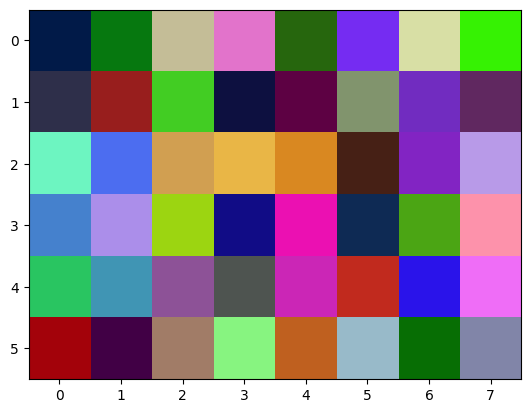

In [ ]:
x = torch.rand(batch_size, context_size, embedding_dim)
plt.imshow(x)

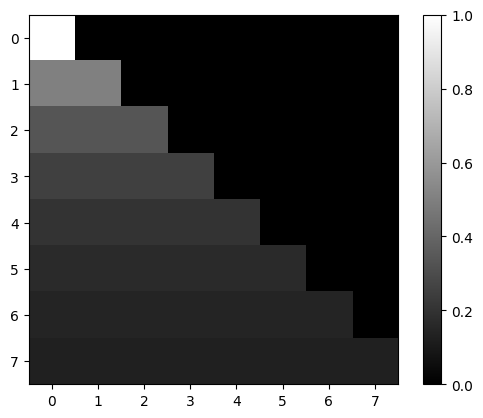

In [ ]:
weights = torch.tril(torch.ones(context_size, context_size))
weights /= weights.sum(dim=1)[:, None]
plt.imshow(weights, cmap="gray")
plt.colorbar()

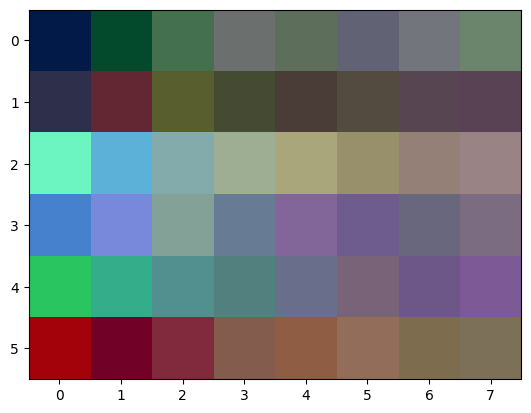

In [ ]:
context = weights[None, :] @ x
plt.imshow(context)

Now every token is transformed into its context until now!

In [26]:
class BigramModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.token_embedder = torch.nn.Embedding(vocab_size, embedding_size)
        self.linear_head = torch.nn.Linear(embedding_size, vocab_size)
    
    def forward(self, idx):
        token_embeddings = self.token_embedder(idx)
        x = token_embeddings
        
        w = torch.tril(torch.ones(x.shape[1], x.shape[1]))
        w /= w.sum(dim=1)[:, None]
        x = w[None, ...] @ x

        y_pred_proba = self.linear_head(x)
        return y_pred_proba
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            Y_pred_proba =  self(idx)
            Y_pred_proba = Y_pred_proba[:, -1, :]  # last time
            Y_pred_proba = F.softmax(Y_pred_proba, dim=-1)
            idx_next = torch.multinomial(Y_pred_proba, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

In [27]:
model = BigramModel(vocab_size, vocab_size)

to have a context for all the past tokens related to it, and no information from the future tokens.

In [29]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
pl_model.training_step(batch, 0)

/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/core/module.py:423: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(4.1730, grad_fn=<NllLossBackward0>)

In [168]:
trainer = pl.Trainer(max_epochs=10, limit_train_batches=1000)
trainer.fit(pl_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | BigramModel | 8.5 K 
--------------------------------------
8.5 K     Trainable params
0         Non-trainable params
8.5 K     Total params
0.034     Total estimated model params size (MB)


Training: |                       | 0/? [00:00<?, ?it/s]


KeyboardInterrupt



In [169]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=500)[0].tolist()))


USESLTEO::rM hOnh:,W p
Au  xNnfe F
ndEy

 a
Ootav 
hhhMloIoM
sane
  rpeMGvl romeo dvy yes'ohlliamwnecoorue' uairtf dioa  Lwagt a
attl shprmocy,rp bo?c o  do,tAthieaoeo sifsetame!farlagursipeer
seaa  !e Bbc;i reult'utr ogvr tym tloh reonobsmasRmhtS,yr  hJkih H ahnwut mWeituht obh  nobns  sBacuRC  yaasl  y
 m atfnyl aru tem tzoide,uc tpreraehne!    rsnhutchamailg,oorGhy 
tt
oic?eohehlietWh
ehmmsh ugm-edaat rd ht ykleImonabeionsw,: ta  di!ad er llWpehVsTsIeep uetieutt  sgs eehcf prCt'i s
ao tead u 


## Self-attention

Attention gives us weighted average of previous embeddings for each token (context), but the weights are based on previous data itself. This is not common!

This not only gives a token embedding valuable context, but...

It is already a non-linearity!

Here is how it works:

$x := embeddings$

$k = key(x)$

$q = query(x)$

$v = value(x)$

$w = q @ k^T$

$w = norm(w)$

$out = w @ v$

The weights are not given as a the output of some linear layer. They are a linear combination of data x data. It is as non-linear as $cxy$ in the following polynomial:

$p(x,y) = ax + by + cxy + d$ (2nd degree polynomial!)

In fact, when we apply w to v it is another non-linear degree.

That is exactly why weights have to be normalized, because they they end up with magnitude of data**2.

In [148]:
class BigramModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_size, head_size, block_size):
        super().__init__()
        self.token_embedder = torch.nn.Embedding(vocab_size, embedding_size)
        self.linear_head = torch.nn.Linear(head_size, vocab_size)
        # self.register_buffer("tril", torch.tril(block_size, block_size))
        self.key = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.query = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.value = torch.nn.Linear(embedding_size, head_size, bias=False)
        
    def forward(self, idx):
        token_embeddings = self.token_embedder(idx)
        x = token_embeddings
        
        # self-attention mechanism start
        k = self.key(x)
        q = self.query(x)
        w = q @ k.transpose(-1, -2)
        w = w / k.shape[-1] ** 0.5
                
        tril = torch.tril(torch.ones(w.shape[-1], w.shape[-1]))
        w = w.masked_fill(tril==0, -torch.inf)
        w = F.softmax(w, dim=-1)
        
        v = self.value(x)
        x = w @ v
        # self-attention mechanism end
        
        y_pred_proba = self.linear_head(x)
        return y_pred_proba
    
    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            Y_pred_proba =  self(idx)
            Y_pred_proba = Y_pred_proba[:, -1, :]  # last time
            Y_pred_proba = F.softmax(Y_pred_proba, dim=-1)
            idx_next = torch.multinomial(Y_pred_proba, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

In [149]:
head_size = 16
embedding_size = 32
block_size = 8
model = BigramModel(vocab_size, embedding_size, head_size, block_size)

In [150]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
pl_model.training_step(batch, 0)

tensor(4.1750, grad_fn=<NllLossBackward0>)

In [ ]:
trainer = pl.Trainer(max_epochs=10, limit_train_batches=1000)
trainer.fit(pl_model)

In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=500)[0].tolist()))


OHARK:
BA:

WWhaine wowancy ver curakCKI d wd:
Ty pnceam s t asy hisstofer he nd nes st, lr s , uriho athosisu
ULile mr re w lousEthme wkinls, ncos
C t amor,
hy hiree ary gd menof d, cotod hithe gor, torthenlrie fofpad arer, or, le awatifee, f havisthy Ie d l hin aldessur hicounooacrrro nmad fl yormdse y, fe atrychy n hey he
S Iren hiicide h thit?Id co acatidif anong
Mae tsp st
:ot r sothe uof tp ond le f thagwed, wlr grmis wm, himed! ashos lsunure, m thad me? wimastte nds su beaniminthor tily! 


Now we can add position information as input to the model, so that we get position

Not better results now. Another important thing in transformer paper is the position embedding. That is: to treat position as data.

In [112]:
class AttentionHead(torch.nn.Module):

    def __init__(self, embedding_size, head_size, block_size):
        super().__init__()
        self.key = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.query = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.value = torch.nn.Linear(embedding_size, head_size, bias=False)
        tril = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer("tril", tril)
        
    def forward(self, x):
        steps = x.shape[1]
        q = self.query(x)
        k = self.key(x)
        w = self.get_weights(q, k, steps)
        v = self.value(x)
        v =  w @ v
        return v
    
    def get_weights(self, q, k, steps):
        w = q @ k.transpose(-1, -2)
        w = w / k.shape[-1] ** 0.5
        tril = self.tril[:steps, :steps]
        w = w.masked_fill(tril==0, -torch.inf)
        w = F.softmax(w, dim=-1)
        return w

class BigramModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_size, head_size, block_size):
        super().__init__()
        self.token_embedder = torch.nn.Embedding(vocab_size, embedding_size)
        self.position_embedder = torch.nn.Embedding(block_size, embedding_size)
        self.attention_head = AttentionHead(embedding_size, head_size, block_size)
        self.linear_head = torch.nn.Linear(head_size, vocab_size)
    
    def forward(self, idx):
        token_embeddings = self.token_embedder(idx)
        
        position = torch.arange(idx.shape[1])
        position_embeddings = self.position_embedder(position)

        x = token_embeddings + position_embeddings
        x = self.attention_head(x)
        y = self.linear_head(x)
        return y
    
    def generate(self, idx, max_new_tokens):
        block_size = self.position_embedder.weight.shape[0]
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            Y_pred_proba =  self(idx_cond)
            Y_pred_proba = Y_pred_proba[:, -1, :]  # last time
            Y_pred_proba = F.softmax(Y_pred_proba, dim=-1)
            idx_next = torch.multinomial(Y_pred_proba, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

In [113]:
head_size = 16
embedding_size = 32
block_size = 8
model = BigramModel(vocab_size, embedding_size, head_size, block_size)

In [114]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
pl_model.training_step(batch, 0)

/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/core/module.py:423: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(4.3378, grad_fn=<NllLossBackward0>)

In [115]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
trainer = pl.Trainer(max_epochs=10, limit_train_batches=1000, log_every_n_steps=100)
trainer.fit(pl_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | BigramModel | 5.0 K 
--------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.020     Total estimated model params size (MB)
/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...

KeyboardInterrupt



In [193]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=500)[0].tolist()))


Mut re mme othand iaithearnty khe
S:
Fagouwr, thin mresle t's ogs:
The ads gto dt mome thre whart ceart tive anganll ngede ikes:
QUEELO:
Thealt gt I, lllereeve thod wio yono ng ble.

The see:
So''s, hiuncicikinmisind, hancoterbu chat sundod fevere;
Pll be

IFriky he for tis ghe ks lioncro bly,
CLY 'ce gpe kpopoerde ifit olain homf wa sury fon undo, ss mod waloto Thingo?
Iertridsie ls.

Jo ls scoourd anucat tlonour ba?
-':
Nor tt cive b.

OR:
Hougn acron gen my ty heexo rtorn kro maca the ilasndr


In [53]:
class AttentionHead(torch.nn.Module):

    def __init__(self, embedding_size, head_size, block_size):
        super().__init__()
        self.key = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.query = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.value = torch.nn.Linear(embedding_size, head_size, bias=False)
        tril = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer("tril", tril)
        
    def forward(self, x):
        steps = x.shape[1]
        q = self.query(x)
        k = self.key(x)
        w = self.get_weights(q, k, steps)
        v = self.value(x)
        v =  w @ v
        return v
    
    def get_weights(self, q, k, steps):
        w = q @ k.transpose(-1, -2)
        w = w / k.shape[-1] ** 0.5
        tril = self.tril[:steps, :steps]
        w = w.masked_fill(tril==0, -torch.inf)
        w = F.softmax(w, dim=-1)
        return w
    
class MultiHeadAttention(torch.nn.Module):
    
    def __init__(self, embedding_size, head_size, n_heads, block_size):
        super().__init__()
        self.heads = torch.nn.ModuleList([
            AttentionHead(embedding_size, head_size, block_size)
            for _ in range(n_heads)
        ])
        
    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

class BigramModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_size, head_size, n_heads, block_size):
        super().__init__()
        self.token_embedder = torch.nn.Embedding(vocab_size, embedding_size)
        self.position_embedder = torch.nn.Embedding(block_size, embedding_size)
        self.multi_head_attention = MultiHeadAttention(embedding_size, head_size, n_heads, block_size)
        self.linear_head = torch.nn.Linear(head_size*n_heads, vocab_size)
        self.register_buffer("position", torch.arange(block_size))
        
    def forward(self, x):
        token_embeddings = self.token_embedder(x)
        position_embeddings = self.position_embedder(self.position[:x.shape[1]])
        x = token_embeddings + position_embeddings
        x = self.multi_head_attention(x)
        y = self.linear_head(x)
        return y
    
    def generate(self, idx, max_new_tokens):
        block_size = self.position_embedder.weight.shape[0]
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            Y_pred_proba =  self(idx_cond)
            Y_pred_proba = Y_pred_proba[:, -1, :]  # last time
            Y_pred_proba = F.softmax(Y_pred_proba, dim=-1)
            idx_next = torch.multinomial(Y_pred_proba, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

In [309]:
embedding_size = 32
block_size = 8
n_heads = 4
head_size = embedding_size // n_heads
model = BigramModel(vocab_size, embedding_size, head_size, n_heads, block_size)

In [310]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
pl_model.training_step(batch, 0)

tensor(4.1169, grad_fn=<NllLossBackward0>)

In [184]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
trainer = pl.Trainer(max_epochs=10, limit_train_batches=1000, log_every_n_steps=100)
trainer.fit(pl_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | BigramModel | 7.6 K 
--------------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.030     Total estimated model params size (MB)
/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...

KeyboardInterrupt



In [68]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=500)[0].tolist()))


ETO'd parrs grat cow
BOLI ry what! evey,
To onge!
Ror' hulland hous,,
Haruert.

BRB
POLAMINCESS:
row he,
Joncu,
Hir
INoque of whist Ha now't now ble:
E Erhat.

No? Yourichey suren your coourngy stherveise gackishe thatdes,
Thin.

CWAUFEMIS: wi wilhtew'd wead uspe Singon.
Whantee net so, men aprt reve ige flis os pored; bent sot heich herir'dd I wha lorr st a dessevernd
Andy:
That winceng enk whe dos ares micarel.

LANRY Pardy: gardescersome ane;
youc I:
rne cowea,
My seer fand rour fighs I your 


In [47]:
class AttentionHead(torch.nn.Module):

    def __init__(self, embedding_size, head_size, block_size, dropout=0.):
        super().__init__()
        self.key = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.query = torch.nn.Linear(embedding_size, head_size, bias=False)
        self.value = torch.nn.Linear(embedding_size, head_size, bias=False)
        tril = torch.tril(torch.ones(block_size, block_size))
        self.register_buffer("tril", tril)
        
    def forward(self, x):
        steps = x.shape[1]
        q = self.query(x)
        k = self.key(x)
        w = self.get_weights(q, k, steps)
        w = self.dropout(w)
        v = self.value(x)
        v =  w @ v
        return v
    
    def get_weights(self, q, k, steps):
        w = q @ k.transpose(-1, -2)
        w = w / k.shape[-1] ** 0.5
        tril = self.tril[:steps, :steps]
        w = w.masked_fill(tril==0, -torch.inf)
        w = F.softmax(w, dim=-1)
        return w
    
class MultiHeadAttention(torch.nn.Module):
    
    def __init__(self, embedding_size, head_size, n_heads, block_size, dropout=0):
        super().__init__()
        self.heads = torch.nn.ModuleList([
            AttentionHead(embedding_size, head_size, block_size, dropout)
            for _ in range(n_heads)
        ])
        
    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

In [48]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=(), act=torch.nn.ReLU, last_act=None, dropout=0.):
        super().__init__()
        if last_act is None:
            last_act = torch.nn.Identity
        sizes = [input_size, *hidden_sizes, output_size]
        layers = []
        for size_in, size_out in zip(sizes[:-1], sizes[1:]):
            layers.append(torch.nn.Linear(size_in, size_out))
            layers.append(act() if size_out != output_size else last_act())
        self.net = torch.nn.Sequential(*layers[:-1])  # Exclude the last activation
        self.dropout = torch.nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.net(x)
        x = self.dropout(x)
        return x

In [49]:
class TransformerBlock(torch.nn.Module):
    
    def __init__(self, embedding_size, n_heads, block_size, ff_hidden_size, dropout=0.):
        super().__init__()
        assert embedding_size % n_heads == 0
        head_size = embedding_size // n_heads
        self.self_attention = MultiHeadAttention(embedding_size, head_size, n_heads, block_size)
        self.mlp = MLP(embedding_size, embedding_size, hidden_sizes=[ff_hidden_size], dropout=dropout)
        self.norm_0 = torch.nn.LayerNorm(embedding_size)
        self.norm_1 = torch.nn.LayerNorm(embedding_size)
        
    def forward(self, x):
        # adding residuals, layer norm and droppout
        x = x + self.self_attention(self.norm_0(x))
        x = x + self.mlp(self.norm_1(x))
        return x

In [144]:
class BigramModel(torch.nn.Module):
    
    def __init__(self, vocab_size, embedding_size, n_heads, n_transformer_blocks, block_size, ff_hidden_size=4, dropout=0.):
        super().__init__()
        self.token_embedder = torch.nn.Embedding(vocab_size, embedding_size)
        self.position_embedder = torch.nn.Embedding(block_size, embedding_size)
        self.blocks = torch.nn.Sequential(*[
            TransformerBlock(embedding_size, n_heads, block_size, ff_hidden_size, dropout=dropout)
            for _ in range(n_transformer_blocks)
        ])
        self.norm = torch.nn.LayerNorm(embedding_size)
        self.linear_head = torch.nn.Linear(embedding_size, vocab_size)
        self.register_buffer("position", torch.arange(block_size))
        
    def forward(self, x):
        token_embeddings = self.token_embedder(x)
        position_embeddings = self.position_embedder(self.position[:x.shape[1]])
        x = token_embeddings + position_embeddings
        x = self.blocks(x)
        x = self.norm(x)
        y = self.linear_head(x)
        return y
    
    def generate(self, idx, max_new_tokens):
        block_size = self.position_embedder.weight.shape[0]
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            Y_pred_proba =  self(idx_cond)
            Y_pred_proba = Y_pred_proba[:, -1, :]  # last time
            Y_pred_proba = F.softmax(Y_pred_proba, dim=-1)
            idx_next = torch.multinomial(Y_pred_proba, num_samples=1)
            idx = torch.cat([idx, idx_next], dim=1)
        return idx

In [360]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
pl_model.training_step(batch, 0)

/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/core/module.py:423: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(1.6275, grad_fn=<NllLossBackward0>)

In [361]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
trainer = pl.Trainer(max_epochs=10, limit_train_batches=1000, log_every_n_steps=100)
trainer.fit(pl_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type        | Params
--------------------------------------
0 | model | BigramModel | 17.9 K
--------------------------------------
17.9 K    Trainable params
0         Non-trainable params
17.9 K    Total params
0.072     Total estimated model params size (MB)
/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...

KeyboardInterrupt



batch_norm: normalize (ONLY) the columns of each batch for mean=0 and std=1.

In [362]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=500)[0].tolist()))



Arably whe broldove hou'lld heor, hat.

Plavave have no oathers but hor e my nat jcme llens aver bam sis't; wil slllok,
I:
Men sish idees thou wold neand helqly.
WAUnd stleenor-':
EN with lllaks', Sall vere thout high
Mis der theat strotmerr
No wreight wre, I noth'd of with hou ghoaghat uthe mex! he gind trean.
Fror whow?
Wgh founch I this me-pcesss ineste whild:
Provioul poour r fourdmt I crout goughe or therd:
Gour lad?
Se weld haste ssemullfor KINothth conttler his twie ll hooverk; you.
MUKI


In [27]:
text_dir = Path("~/jrn").expanduser()
text_paths = list(text_dir.glob("*.md"))

text = []
for path in text_dir.glob("*.md"):
    try:
        with open(path, "r") as f:
            text.append(f.read())
    except:
        pass
text = "\n\n".join(text)

In [92]:
tokenizer = tiktoken.encoding_for_model("gpt-4")
tokens_tiktoken = tokenizer.encode(text)

In [109]:
from sklearn.preprocessing import LabelEncoder
unique_tokens = sorted(set(tokens_tiktoken))
n_vocab = len(unique_tokens)

label_encoder = LabelEncoder()
label_encoder.fit(unique_tokens)
tokens = label_encoder.transform(tokens_tiktoken)
tokens_tiktoken_decoded = label_encoder.inverse_transform(encoded_data)

In [110]:
data = torch.as_tensor(tokens)

In [111]:
len(data)/len(text)

0.2773350736814395

In [112]:
tokenizer.n_vocab

100277

In [113]:
len({*tokens})

5809

In [178]:
torch.manual_seed(1337)

batch_size = 4

n = int(0.8 * len(data))
train_data = data[:n]
test_data = data[n:]

train_dataset = SequenceDataset(train_data, block_size=block_size)
test_dataset = SequenceDataset(test_data, block_size=block_size)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

sample = next(iter(train_dataset))
batch = next(iter(train_loader))

In [179]:
batch_size = 4
n_heads = 8
head_size = 64
embedding_size = head_size * n_heads
block_size = 32
vocab_size = len({*tokens})
dropout = 0.4
# vocab_size = tokenizer.n_vocab
n_transformer_blocks = 4
ff_hidden_size = 4
model = BigramModel(vocab_size, embedding_size, n_heads, n_transformer_blocks, block_size, ff_hidden_size, dropout=dropout)

In [180]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
pl_model.training_step(batch, 0)

/home/marcosrdac/.conda/lib/python3.9/site-packages/pytorch_lightning/core/module.py:423: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tensor(8.8694, grad_fn=<NllLossBackward0>)

In [181]:
def decode(s):
    return tokenizer.decode(label_encoder.inverse_transform(s.tolist()))

In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model.generate(idx, max_new_tokens=20)[0]))

In [ ]:
pl_model = LanguageModel(model, train_dataset=train_dataset, batch_size=32)
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=100, accelerator="xla")
trainer.fit(pl_model)

In [161]:
model_eval = model.eval()

In [ ]:
idx = torch.zeros((1, 1), dtype=torch.long)
print(decode(model_eval.generate(idx, max_new_tokens=100)[0]))

In [165]:
s = "Meu nome é"

In [175]:
t = torch.as_tensor(encoder.transform(tokenizer.encode(s))[None, :])

In [ ]:
print(decode(model_eval.generate(t, max_new_tokens=100)[0]))

In [ ]:
class MultiHeadSelfAttention(torch.nn.Module):

    def __init__(self, n_embd, n_head, is_causal=False, bias=True, dropout=0.):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_embd = n_embd
        self.n_head = n_head
        self.head_size = n_embd // n_head
        self.is_causal = is_causal
        self.qkv = torch.nn.Linear(n_embd, 3*n_embd, bias=bias)
        self.projection = torch.nn.Linear(n_embd, n_embd, bias=bias)
        # regularization
        self.dropout = dropout

    def forward(self, x, mask=None):
        qkv = self.qkv(x)
        q, k, v  = torch.split(qkv, self.n_embd, dim=-1)        
        # unpack heads to 2nd dim
        k = k.view(*x.shape[:2], self.n_head, self.head_size).transpose(1, 2)
        q = q.view(*x.shape[:2], self.n_head, self.head_size).transpose(1, 2)
        v = v.view(*x.shape[:2], self.n_head, self.head_size).transpose(1, 2)
        
        dropout = self.dropout if self.training else 0.
        y = F.scaled_dot_product_attention(q, k, v, attn_mask=mask, dropout_p=dropout, is_causal=self.is_causal)        
        y = y.transpose(1, 2).contiguous().view(x.shape)
        y = self.projection(y)
        return y